<a href="https://colab.research.google.com/github/eddercipras/maiz/blob/main/my_resnet_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import datetime, os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -q /content/drive/MyDrive/archive.zip

replace data/Blight/Corn_Blight (1).jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
!ls data

Blight	Common_Rust  Gray_Leaf_Spot  Healthy


In [5]:
# params
image_size = (240, 240)
# params
batch_size = 32

# node
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
# node
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 4188 files belonging to 4 classes.
Using 3351 files for training.
Found 4188 files belonging to 4 classes.
Using 837 files for validation.


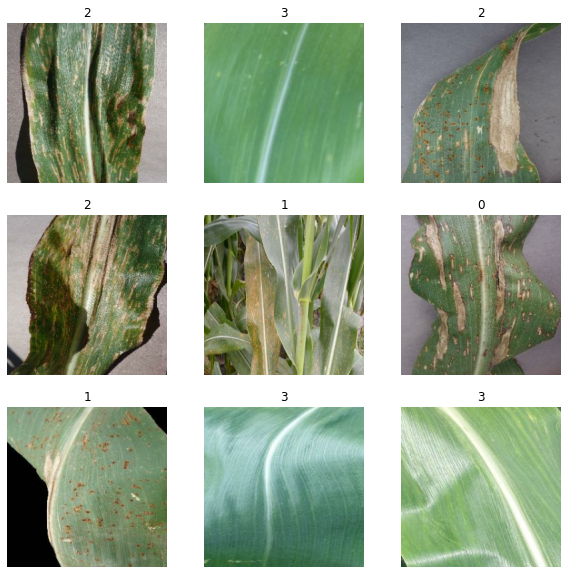

In [6]:
# node
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
# node
data_augmentation = keras.Sequential(
    [
        # # Rotación de imágenes horizontal y vertical
        layers.RandomFlip(mode="horizontal"),
        # Rotación 
        layers.RandomRotation(fill_mode='reflect', 
        interpolation='bilinear',
        factor=(-0.1, 0.1)),
        layers.RandomZoom(height_factor=(-0.1, 0.1),
        width_factor=(-0.1, 0.1)),
    ]
)

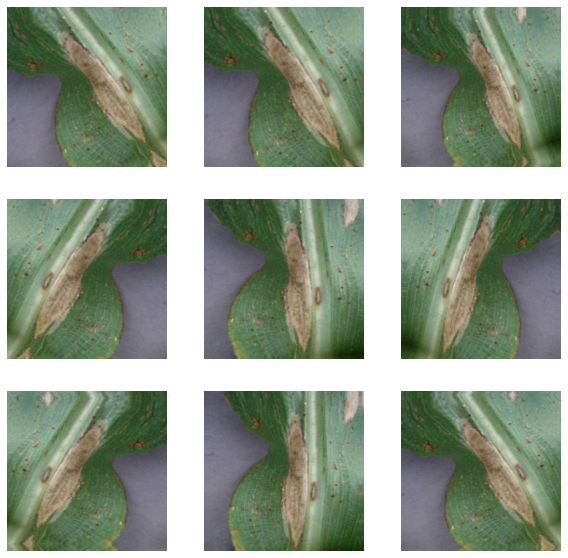

In [8]:
# node
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
# node
train_ds = train_ds.prefetch(buffer_size=32)
# node
val_ds = val_ds.prefetch(buffer_size=32)

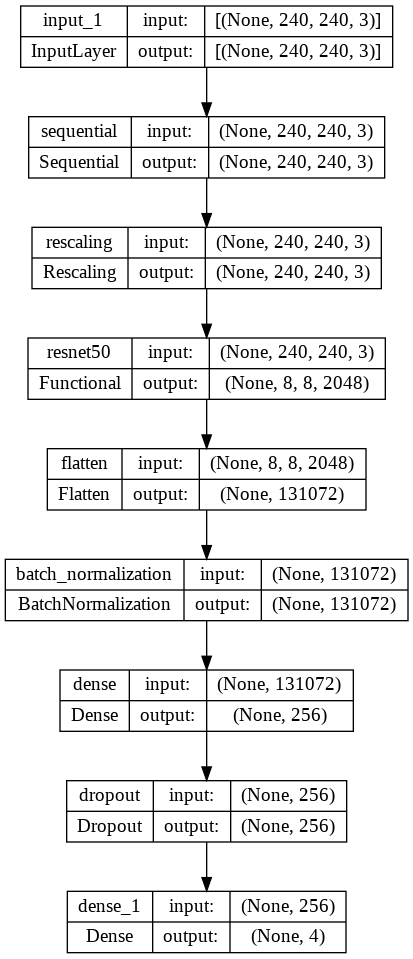

In [10]:
# node
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    
    # Pretrained model
    base_model = keras.applications.ResNet50(
        include_top=False,
        weights="imagenet", # logging loading...
        input_shape=input_shape)
    
    # Head plugged to the pretrained model
    outputs = base_model(x)
    outputs = layers.Flatten()(outputs)
    outputs = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(outputs)
    outputs = layers.Dense(256, 
                           kernel_regularizer = regularizers.l2(l = 0.016), 
                           activity_regularizer = regularizers.l1(0.006), 
                           bias_regularizer = regularizers.l1(0.006), 
                           activation = 'relu')(outputs)
    outputs = layers.Dropout(rate = 0.45, seed = 123)(outputs)
    outputs = layers.Dense(4, activation="softmax")(outputs)
    
    return keras.Model(inputs, outputs)

# node
model = make_model(input_shape=image_size + (3,), num_classes = 4)
# logging
keras.utils.plot_model(model, show_shapes=True)

In [11]:
%load_ext tensorboard

In [12]:
# epochs = 20

# my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=3),
#     # tf.keras.callbacks.LearningRateScheduler(scheduler),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001),
#     # tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
#     tf.keras.callbacks.TensorBoard(log_dir='./logs'),
# ]

# # callbacks = [
# #     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# # ]
# model.compile(
#     optimizer=keras.optimizers.Adamax(learning_rate=1e-3),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=["accuracy"],
# )
# model.fit(train_ds, epochs=epochs, 
#           callbacks=[my_callbacks], validation_data=val_ds,)

In [ ]:
# This params gave me around 92%
epochs = 50

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    # tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
    # tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
model.fit(train_ds, epochs=epochs, 
          callbacks=[my_callbacks], validation_data=val_ds,)

Epoch 1/50
105/105 [==============================] - 69s 495ms/step - loss: 12.4236 - accuracy: 0.8242 - val_loss: 11.0801 - val_accuracy: 0.2772 - lr: 0.0010
Epoch 2/50
105/105 [==============================] - 49s 466ms/step - loss: 7.7963 - accuracy: 0.8908 - val_loss: 7.4978 - val_accuracy: 0.2640 - lr: 0.0010
Epoch 3/50
105/105 [==============================] - 49s 463ms/step - loss: 5.6127 - accuracy: 0.9167 - val_loss: 5.7972 - val_accuracy: 0.2987 - lr: 0.0010
Epoch 4/50
105/105 [==============================] - 49s 467ms/step - loss: 4.1575 - accuracy: 0.9302 - val_loss: 4.5973 - val_accuracy: 0.2939 - lr: 0.0010
Epoch 5/50
105/105 [==============================] - 49s 464ms/step - loss: 3.1175 - accuracy: 0.9317 - val_loss: 3.8461 - val_accuracy: 0.2581 - lr: 0.0010
Epoch 6/50
105/105 [==============================] - 49s 465ms/step - loss: 2.3854 - accuracy: 0.9400 - val_loss: 3.2019 - val_accuracy: 0.3262 - lr: 0.0010
Epoch 7/50
105/105 [==============================

In [ ]:
# epochs = 50
# logdir = os.path.join("/content/drive/MyDrive/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# my_callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, min_lr=0.000001),
#     tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1),
#     tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/models/model.{epoch:02d}-{val_loss:.2f}.h5'),
#     tf.keras.callbacks.TensorBoard(log_dir=logdir),
# ]

# # callbacks = [
# #     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# # ]
# model.compile(
#     optimizer=keras.optimizers.Adamax(learning_rate=1e-3),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=["accuracy"],
# )
# model.fit(train_ds, epochs=epochs, 
#           callbacks=[my_callbacks], validation_data=val_ds,)

In [ ]:
%tensorboard --logdir logs

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/data/Blight/Corn_Blight (100).jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

In [ ]:
predictions